In [1]:
from collections import defaultdict
import csv
from itertools import islice
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
import torch
from torchvision import models, transforms, datasets

In [3]:
progan_filenames = torch.load('progan_filenames.pt', map_location=torch.device('cpu'))
progan_distance_features = torch.load('small_progan_distance_features.pt', map_location=torch.device('cpu'))

In [4]:
stylegan_filenames = torch.load('stylegan_filenames.pt', map_location=torch.device('cpu'))
stylegan_distance_features = torch.load('stylegan_distance_features.pt', map_location=torch.device('cpu'))

In [2]:
began_filenames = torch.load('began_filenames.pt', map_location=torch.device('cpu'))
began_distance_features = torch.load('began_distance_features.pt', map_location=torch.device('cpu'))

In [5]:
dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        if dataset_name == 'began5000' and row['realness'] == 'True': print(row)

        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [7]:
progan_votes = img_votes['progan5000']
began_votes = img_votes['began5000']
stylegan_votes = img_votes['styleganceleba5000']
len(progan_votes), len(began_votes), len(stylegan_votes)

(2233, 2397, 3103)

In [14]:
began_votes_filtered = {k:v for k,v in began_votes.items() if k in [os.path.split(x)[-1] for x in began_filenames]}

len(began_votes_filtered)

1966

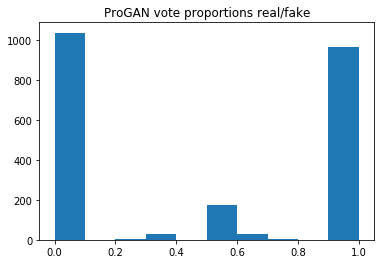

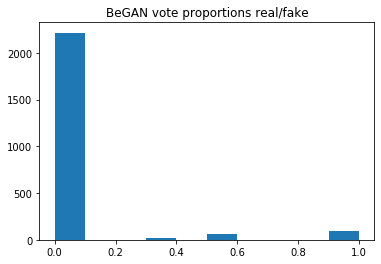

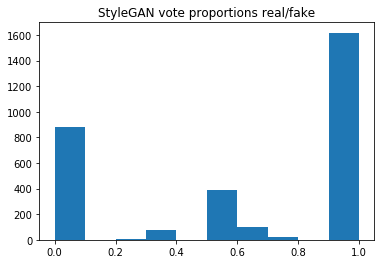

In [15]:
for gan, votes in [('ProGAN', progan_votes), ('BeGAN', began_votes), ('StyleGAN', stylegan_votes)]:
    vote_pct_correct = [y/(x+y) for x,y in votes.values()]
    plt.title(gan + ' vote proportions real/fake')
    plt.hist(vote_pct_correct)
    plt.show()

In [18]:
with open('train_set.txt') as f:
    progan_train_files = [x.strip() for x in f.readlines()]
#print(progan_train_files[:5])

with open('val_set.txt') as f:
    progan_val_files = [x.strip() for x in f.readlines()]
#print(progan_val_files[:5])

with open('stylegan_train_set.txt') as f:
    stylegan_train_files = [x.strip() for x in f.readlines()]
#print(stylegan_train_files[:5])

with open('stylegan_val_set.txt') as f:
    stylegan_val_files = [x.strip() for x in f.readlines()]
#print(stylegan_val_files[:5])

with open('began_train_set.txt') as f:
    began_train_files = [x.strip() for x in f.readlines()]
#print(began_train_files[:5])

with open('began_val_set.txt') as f:
    began_val_files = [x.strip() for x in f.readlines()]
#print(began_val_files[:5])

In [19]:
progan_features_by_file = {progan_filenames[i] : progan_distance_features[i] for i in range(len(progan_filenames))}
print(len(progan_features_by_file))

stylegan_features_by_file = {stylegan_filenames[i] : stylegan_distance_features[i] for i in range(len(stylegan_filenames))}
print(len(stylegan_features_by_file))

began_features_by_file = {began_filenames[i] : began_distance_features[i] for i in range(len(began_filenames))}
print(len(began_features_by_file))

2233
3103
1966


In [21]:
progan_votes_by_file = {'imgs_by_label/progan_labeled/progan_labeled_imgs/' + k : v for k,v in progan_votes.items()}
print(len(progan_votes_by_file))

stylegan_votes_by_file = {'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/' + k : v for k,v in stylegan_votes.items()}
print(len(stylegan_votes_by_file))

began_votes_by_file = {'imgs_by_label/began_labeled/began_labeled_imgs/' + k : v for k,v in began_votes_filtered.items()}
print(len(began_votes_by_file))

2233
3103
1966


In [22]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_progan_train = []
Y_progan_train = []
for f in tqdm_notebook(progan_train_files):
    cur_feats = progan_features_by_file[f]
    cur_votes = progan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    #print(false_votes + true_votes)
    #print(f, cur_feats, cur_votes, '\n')
    
    for i in range(false_votes):
        X_progan_train.append(cur_feats)
        Y_progan_train.append(0)
        
    for i in range(true_votes):
        X_progan_train.append(cur_feats)
        Y_progan_train.append(1)

len(X_progan_train), len(Y_progan_train)

(2369, 2369)

In [26]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_progan_val = []
Y_progan_val = []
for f in tqdm_notebook(progan_val_files):
    cur_feats = progan_features_by_file[f]
    cur_votes = progan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_progan_val.append(cur_feats)
        Y_progan_val.append(0)
        
    for i in range(true_votes):
        X_progan_val.append(cur_feats)
        Y_progan_val.append(1)
len(X_progan_val), len(Y_progan_val)

(306, 306)

In [37]:
lr_progan = LogisticRegression().fit(X_progan_train, Y_progan_train)
lr_progan.score(X_progan_train, Y_progan_train), lr_progan.score(X_progan_val, Y_progan_val)

/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.6361333896158716, 0.6503267973856209)

In [28]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_stylegan_train = []
Y_stylegan_train = []
for f in tqdm_notebook(stylegan_train_files):
    cur_feats = stylegan_features_by_file[f]
    cur_votes = stylegan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_stylegan_train.append(cur_feats)
        Y_stylegan_train.append(0)
        
    for i in range(true_votes):
        X_stylegan_train.append(cur_feats)
        Y_stylegan_train.append(1)

len(X_stylegan_train), len(Y_stylegan_train)

(3849, 3849)

In [29]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_stylegan_val = []
Y_stylegan_val = []
for f in tqdm_notebook(stylegan_val_files):
    cur_feats = stylegan_features_by_file[f]
    cur_votes = stylegan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_stylegan_val.append(cur_feats)
        Y_stylegan_val.append(0)
        
    for i in range(true_votes):
        X_stylegan_val.append(cur_feats)
        Y_stylegan_val.append(1)
len(X_stylegan_val), len(Y_stylegan_val)

(485, 485)

In [38]:
lr_stylegan = LogisticRegression().fit(X_stylegan_train, Y_stylegan_train)
lr_stylegan.score(X_stylegan_train, Y_stylegan_train), lr_stylegan.score(X_stylegan_val, Y_stylegan_val)

/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.6282151208106002, 0.6639175257731958)

In [31]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_began_train = []
Y_began_train = []
for f in tqdm_notebook(began_train_files):
    cur_feats = began_features_by_file[f]
    cur_votes = began_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_began_train.append(cur_feats)
        Y_began_train.append(0)
        
    for i in range(true_votes):
        X_began_train.append(cur_feats)
        Y_began_train.append(1)

len(X_began_train), len(Y_began_train)

(2140, 2140)

In [32]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_began_val = []
Y_began_val = []
for f in tqdm_notebook(began_val_files):
    cur_feats = began_features_by_file[f]
    cur_votes = began_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_began_val.append(cur_feats)
        Y_began_val.append(0)
        
    for i in range(true_votes):
        X_began_val.append(cur_feats)
        Y_began_val.append(1)
len(X_began_val), len(Y_began_val)

(248, 248)

In [39]:
lr_began = LogisticRegression().fit(X_began_train, Y_began_train)
lr_began.score(X_began_train, Y_began_train), lr_began.score(X_began_val, Y_began_val)

/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9457943925233645, 0.9556451612903226)

P-correct for each example
0.5509021380125019 0.14111175386278635


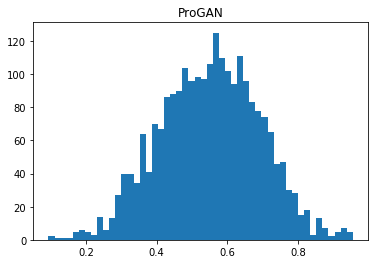

0.5404354440023837 0.13265175526874465


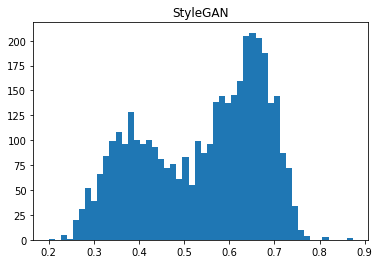

0.8975330884284839 0.20172465325344524


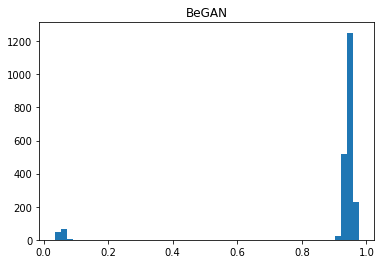

In [46]:
print('P-correct for each example')

probs = lr_progan.predict_proba(X_progan_train)
true_probs = np.array([probs[i][Y_progan_train[i]] for i in range(len(probs))])

plt.hist(true_probs, bins=50)
print(np.mean(true_probs), np.std(true_probs))
plt.title('ProGAN')
plt.show()


probs = lr_stylegan.predict_proba(X_stylegan_train)
true_probs = np.array([probs[i][Y_stylegan_train[i]] for i in range(len(probs))])

plt.hist(true_probs, bins=50)
print(np.mean(true_probs), np.std(true_probs))
plt.title('StyleGAN')
plt.show()

probs = lr_began.predict_proba(X_began_train)
true_probs = np.array([probs[i][Y_began_train[i]] for i in range(len(probs))])

plt.hist(true_probs, bins=50)
print(np.mean(true_probs), np.std(true_probs))
plt.title('BeGAN')
plt.show()

Now, for the inter-GAN comparisons:

In [51]:
lr_progan.score(X_stylegan_train, Y_stylegan_train), lr_progan.score(X_stylegan_val, Y_stylegan_val) 

(0.614445310470252, 0.6474226804123712)

In [52]:
lr_progan.score(X_began_train, Y_began_train), lr_progan.score(X_began_val, Y_began_val) 

(0.6224299065420561, 0.6451612903225806)

In [53]:
lr_stylegan.score(X_progan_train, Y_progan_train), lr_stylegan.score(X_progan_val, Y_progan_val) 

(0.6103841283241874, 0.5882352941176471)

In [54]:
lr_stylegan.score(X_began_train, Y_began_train), lr_stylegan.score(X_began_val, Y_began_val) 

(0.3644859813084112, 0.3951612903225806)

In [55]:
lr_began.score(X_progan_train, Y_progan_train), lr_began.score(X_progan_val, Y_progan_val) 

(0.5056986070071761, 0.5294117647058824)

In [56]:
lr_began.score(X_stylegan_train, Y_stylegan_train), lr_began.score(X_stylegan_val, Y_stylegan_val) 

(0.38867238243699664, 0.3422680412371134)

And now to train on 2 datasets at a time

In [62]:
lr_progan_stylegan = LogisticRegression().fit(X_progan_train + X_stylegan_train, Y_progan_train + Y_stylegan_train)
print(lr_progan_stylegan.score(X_progan_train + X_stylegan_train, Y_progan_train + Y_stylegan_train))
print(lr_progan_stylegan.score(X_progan_val + X_stylegan_val, Y_progan_val + Y_stylegan_val))

print('\nAnd now on BeGAN')
print(lr_progan_stylegan.score(X_began_train, Y_began_train))
print(lr_progan_stylegan.score(X_began_val, Y_began_val))


0.6276937922161466
0.6485461441213654

And now on BeGAN
0.49439252336448597
0.5161290322580645


/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [63]:
lr_progan_began = LogisticRegression().fit(X_progan_train + X_began_train, Y_progan_train + Y_began_train)
print(lr_progan_began.score(X_progan_train + X_began_train, Y_progan_train + Y_began_train))
print(lr_progan_began.score(X_progan_val + X_began_val, Y_progan_val + Y_began_val))

print('\nAnd now on stylegan')
print(lr_progan_began.score(X_stylegan_train, Y_stylegan_train))
print(lr_progan_began.score(X_stylegan_val, Y_stylegan_val))


0.759591927256598
0.779783393501805

And now on stylegan
0.5401402961808262
0.511340206185567


/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [64]:
lr_stylegan_began = LogisticRegression().fit(X_stylegan_train + X_began_train, Y_stylegan_train + Y_began_train)
print(lr_stylegan_began.score(X_stylegan_train + X_began_train, Y_stylegan_train + Y_began_train))
print(lr_stylegan_began.score(X_stylegan_val + X_began_val, Y_stylegan_val + Y_began_val))

print('\nAnd now on progan')
print(lr_stylegan_began.score(X_progan_train, Y_progan_train))
print(lr_stylegan_began.score(X_progan_val, Y_progan_val))


0.7064618467189848
0.6766712141882674

And now on progan
0.5892781764457578
0.6274509803921569


/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
